In [1]:
import numpy as np
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('monthly-beer-production-in-austr.csv')
df.head()

,Month,Monthly beer production
0,1956-01,93.2
1,1956-02,96.0
2,1956-03,95.2
3,1956-04,77.1
4,1956-05,70.9


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 476 entries, 0 to 475
Data columns (total 2 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Month                    476 non-null    object 
 1   Monthly beer production  476 non-null    float64
dtypes: float64(1), object(1)
memory usage: 7.6+ KB


In [4]:
# convert month to datetime
df.Month = pd.to_datetime(df.Month)

df = df.set_index("Month")
df.head()

,Monthly beer production
Month,
1956-01-01,93.2
1956-02-01,96.0
1956-03-01,95.2
1956-04-01,77.1
1956-05-01,70.9


[Text(0.5, 0, 'Dates'), Text(0, 0.5, 'Total Production')]

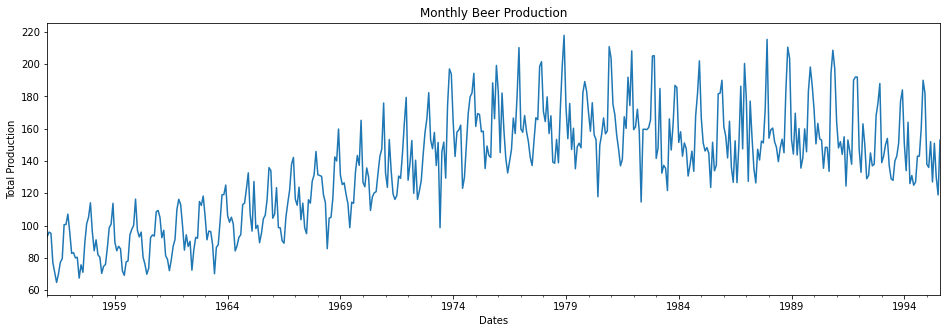

In [5]:
df.index.freq = 'MS'

ax = df['Monthly beer production'].plot(figsize = (16,5),
                                         title = 'Monthly Beer Production')

ax.set(xlabel = 'Dates', ylabel='Total Production')

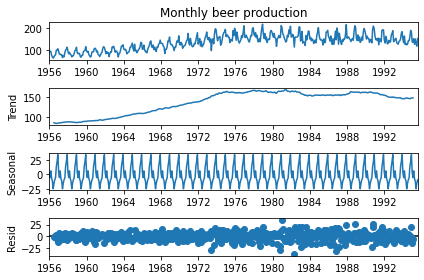

In [6]:
# use the seasonal decompose function to analyze the seasonality of the beer production
a = seasonal_decompose(df['Monthly beer production'], model = "add")
a.plot();

<AxesSubplot:xlabel='Month'>

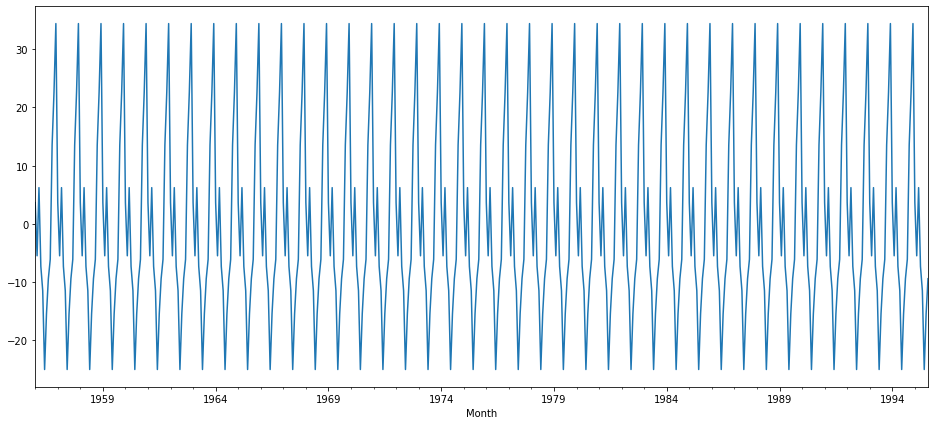

In [7]:
import matplotlib.pyplot as plt
plt.figure(figsize = (16, 7))
a.seasonal.plot()

### Use auto arima to get the best p, d, q, P, D, Q values

In [8]:
auto_arima(df['Monthly beer production'], seasonal=True,
          m=12, max_p=7, max_d=5, max_q=7, max_P=4, max_D=4,
          max_Q=4).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  476
Model:             SARIMAX(5, 1, 4)x(1, 0, [1], 12)   Log Likelihood               -1724.014
Date:                              Sun, 29 Aug 2021   AIC                           3472.028
Time:                                      14:02:01   BIC                           3521.987
Sample:                                           0   HQIC                          3491.674
                                              - 476                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2303      0.055     -4.195      0.000      -0.338      -0.123
ar.L2         -0.1053      0.060     -1.756      0.079      -0.223       0.012
ar.L3          0.7397      0.057     12.907      0.000       0.627       0.852
ar.L4         -0.1396      0.049     -2.856      0.004      -0.235      -0.044
ar.L5          0.0233      0.048      0.480      0.631      -0.072       0.118
ma.L1         -0.7425      0.035    -21.143      0.000      -0.811      -0.674
ma.L2         -0.1714      0.025     -6.778      0.000      -0.221      -0.122
ma.L3         -0.8017      0.024    -33.435      0.000      -0.849      -0.755
ma.L4          0.8581      0.031     27.671      0.000       0.797       0.919
ar.S.L12       0.9946      0.004    223.712      0.000       0.986       1.003
ma.S.L12      -0.8162      0.037    -22.009      0.000      -0.889      -0.743
sigma2        78.8927      4.283     18.420      0.000      70.498      87.287
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):                69.00
Prob(Q):                              0.83   Prob(JB):                         0.00
Heteroskedasticity (H):               2.93   Skew:                            -0.32
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.76
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## The best model from auto_arima is

SARIMAX(5, 1, 4)x(1, 0, [1], 12)

### Split the data into train and test set

In [9]:
train_data = df[:len(df) - 12]
test_data = df[len(df) - 12:]

arima_model = SARIMAX(train_data['Monthly beer production'],
                     order = (5, 1, 4),
                     seasonal_order = (1, 0, 1, 12))

arima_result = arima_model.fit()
arima_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:              Monthly beer production   No. Observations:                  464
Model:             SARIMAX(5, 1, 4)x(1, 0, [1], 12)   Log Likelihood               -1680.906
Date:                              Sun, 29 Aug 2021   AIC                           3385.811
Time:                                      14:02:04   BIC                           3435.464
Sample:                                  01-01-1956   HQIC                          3405.358
                                       - 08-01-1994                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2874      0.064     -4.480      0.000      -0.413      -0.162
ar.L2         -0.1541      0.071     -2.168      0.030      -0.294      -0.015
ar.L3          0.6618      0.075      8.788      0.000       0.514       0.809
ar.L4         -0.1731      0.051     -3.398      0.001      -0.273      -0.073
ar.L5         -0.0164      0.052     -0.317      0.751      -0.118       0.085
ma.L1         -0.6917      0.051    -13.618      0.000      -0.791      -0.592
ma.L2         -0.1640      0.031     -5.225      0.000      -0.225      -0.102
ma.L3         -0.7811      0.030    -26.156      0.000      -0.840      -0.723
ma.L4          0.8060      0.044     18.231      0.000       0.719       0.893
ar.S.L12       0.9956      0.004    265.246      0.000       0.988       1.003
ma.S.L12      -0.8233      0.034    -23.979      0.000      -0.891      -0.756
sigma2        75.5364      3.939     19.178      0.000      67.817      83.256
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                72.14
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               3.69   Skew:                            -0.31
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [10]:
# make predictions start from the end of the training data length
arima_pred = arima_result.predict(start = len(train_data),
                                end = len(df) -1,
                                typ='levels').rename("ARIMA Predictions")

arima_pred

1994-09-01    134.803448
1994-10-01    156.988663
1994-11-01    178.631673
1994-12-01    181.376572
1995-01-01    140.555497
1995-02-01    139.096892
1995-03-01    147.642973
1995-04-01    132.680013
1995-05-01    136.441322
1995-06-01    116.705377
1995-07-01    128.052039
1995-08-01    139.558638
Freq: MS, Name: ARIMA Predictions, dtype: float64

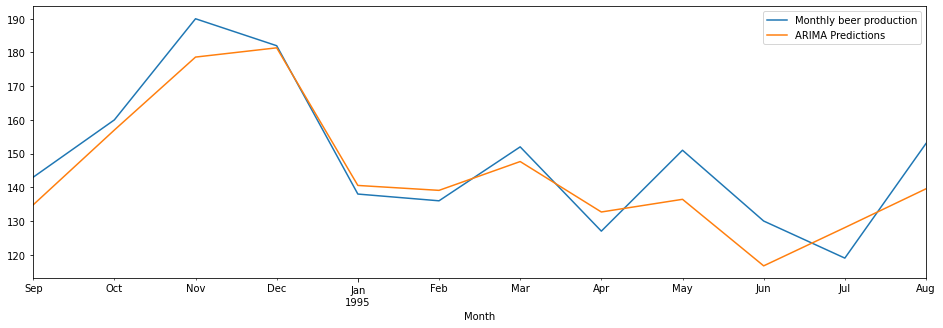

In [11]:
# plot the predictions vs the actual production
test_data['Monthly beer production'].plot(figsize=(16,5), legend=True)

arima_pred.plot(legend=True);

### View the stat metrics on these predictions

In [12]:
arima_rmse_error = rmse(test_data['Monthly beer production'], arima_pred)
arima_mse_error = arima_rmse_error**2
mean_value = df['Monthly beer production'].mean()

print(f'MSE Error: {arima_mse_error}\nRMSE Error:{arima_rmse_error}\nMean: {mean_value}')

MSE Error: 77.04653320347342
RMSE Error:8.777615462269546
Mean: 136.39537815126045


In [13]:
test_data['ARIMA_Predictions'] = arima_pred

## LSTM Forecast

In [14]:
print('Test data:', test_data, '\n\n', 'Train data:', train_data)

Test data:             Monthly beer production  ARIMA_Predictions
Month                                                 
1994-09-01                    143.0         134.803448
1994-10-01                    160.0         156.988663
1994-11-01                    190.0         178.631673
1994-12-01                    182.0         181.376572
1995-01-01                    138.0         140.555497
1995-02-01                    136.0         139.096892
1995-03-01                    152.0         147.642973
1995-04-01                    127.0         132.680013
1995-05-01                    151.0         136.441322
1995-06-01                    130.0         116.705377
1995-07-01                    119.0         128.052039
1995-08-01                    153.0         139.558638 

 Train data:             Monthly beer production
Month                              
1956-01-01                     93.2
1956-02-01                     96.0
1956-03-01                     95.2
1956-04-01              

In [15]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

scaler.fit(train_data)
scaled_train_data = scaler.transform(train_data)
scaled_test_data = scaler.transform(test_data[['Monthly beer production']])

### Create a Time Series Generator

In [16]:
from keras.preprocessing.sequence import TimeseriesGenerator

n_input = 12
n_features = 1
generator = TimeseriesGenerator(scaled_train_data,
                               scaled_train_data, 
                                length=n_input,
                                batch_size=1)

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

lstm_model = Sequential()
lstm_model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features)))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')

lstm_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 200)               161600    
_________________________________________________________________
dense (Dense)                (None, 1)                 201       
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________


In [17]:
lstm_model.fit_generator(generator, epochs=20)

Epoch 1/20
452/452 [==============================] - 5s 8ms/step - loss: 0.0217
Epoch 2/20
452/452 [==============================] - 4s 8ms/step - loss: 0.0123
Epoch 3/20
452/452 [==============================] - 4s 8ms/step - loss: 0.0094
Epoch 4/20
452/452 [==============================] - 5s 10ms/step - loss: 0.0090
Epoch 5/20
452/452 [==============================] - 5s 10ms/step - loss: 0.0073
Epoch 6/20
452/452 [==============================] - 4s 10ms/step - loss: 0.0075
Epoch 7/20
452/452 [==============================] - 4s 9ms/step - loss: 0.0074
Epoch 8/20
452/452 [==============================] - 4s 8ms/step - loss: 0.0073
Epoch 9/20
452/452 [==============================] - 4s 8ms/step - loss: 0.0077
Epoch 10/20
452/452 [==============================] - 4s 8ms/step - loss: 0.0074
Epoch 11/20
452/452 [==============================] - 4s 8ms/step - loss: 0.0071
Epoch 12/20
452/452 [==============================] - 4s 8ms/step - loss: 0.0063
Epoch 13/20
452/452 [=

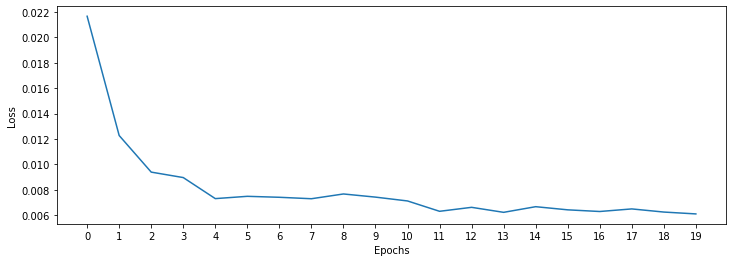

In [18]:
losses_lstm = lstm_model.history.history['loss']
plt.figure(figsize=(12,4))
plt.xlabel('Epochs')
plt.ylabel("Loss")
plt.xticks(np.arange(0, 21, 1))
plt.plot(range(len(losses_lstm)), losses_lstm);

In [19]:
lstm_predictions_scaled = list()

batch = scaled_train_data[-n_input:]
current_batch = batch.reshape((1, n_input, n_features))

for i in range(len(test_data)):
    lstm_pred = lstm_model.predict(current_batch)[0]
    lstm_predictions_scaled.append(lstm_pred)
    current_batch = np.append(current_batch[:, 1:, :],
                             [[lstm_pred]], axis=1)

In [20]:
lstm_predictions_scaled

[array([0.52340436], dtype=float32),
 array([0.60264677], dtype=float32),
 array([0.7122299], dtype=float32),
 array([0.72204167], dtype=float32),
 array([0.5565545], dtype=float32),
 array([0.5209611], dtype=float32),
 array([0.58906895], dtype=float32),
 array([0.43600288], dtype=float32),
 array([0.43898186], dtype=float32),
 array([0.4178163], dtype=float32),
 array([0.43780303], dtype=float32),
 array([0.4992042], dtype=float32)]

In [21]:
# use inverse transform to turn the values back into unscaled values
lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)

lstm_predictions

array([[144.88086705],
       [157.00495552],
       [173.77117585],
       [175.27237498],
       [149.95283793],
       [144.50704919],
       [154.92754923],
       [131.50844069],
       [131.96422471],
       [128.7258956 ],
       [131.78386359],
       [141.17824085]])

In [22]:
test_data['LSTM_Predictions'] = lstm_predictions
test_data

,Monthly beer production,ARIMA_Predictions,LSTM_Predictions
Month,,,
1994-09-01,143.0,134.803448,144.880867
1994-10-01,160.0,156.988663,157.004956
1994-11-01,190.0,178.631673,173.771176
1994-12-01,182.0,181.376572,175.272375
1995-01-01,138.0,140.555497,149.952838
1995-02-01,136.0,139.096892,144.507049
1995-03-01,152.0,147.642973,154.927549
1995-04-01,127.0,132.680013,131.508441
1995-05-01,151.0,136.441322,131.964225


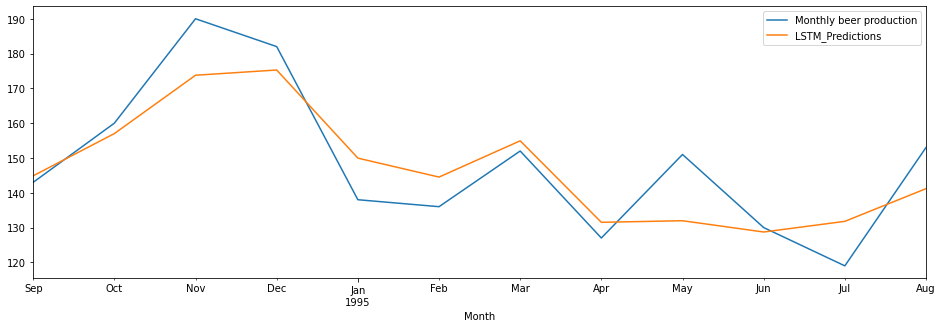

In [23]:
# plot the results of the LSTM predictions vs actual values
test_data['Monthly beer production'].plot(figsize=(16,5), legend=True)
test_data['LSTM_Predictions'].plot(legend=True);

In [24]:
lstm_rmse_error = rmse(test_data['Monthly beer production'],
                      test_data['LSTM_Predictions'])
lstm_mse_error = lstm_rmse_error**2
mean_value = df['Monthly beer production'].mean()

print(f'MSE Error: {lstm_mse_error}\nRMSE Error: {lstm_rmse_error}\nMean: {mean_value}')

MSE Error: 102.70380558700703
RMSE Error: 10.134288607840563
Mean: 136.39537815126045
